# Fuel Prices Analysis (United Kingdom Data)

## Research Goals

- Identify how fuel prices fluctuate over time and determine key patterns.
- Analyze the impact of external factors such as supply chain disruptions, oil prices, VAT, inflation, and geopolitical events on fuel prices.
- Compare fuel price trends across different time periods to understand long-term changes.
- Use machine learning models to predict future fuel price movements based on historical data.
- Store and process data efficiently using **AWS S3** and **Snowflake**, ensuring scalability and reliability.
- Present findings through interactive **Power BI** dashboards and **Plotly Dash** visualizations for clear and actionable insights.
- Implement a **deployment mode** for predictive models, allowing real-time or batch forecasting of fuel prices.

## Step 2: Inflation.ipynb Objectives
- Collect real-time and historical inflation price data from various sources.
- Process and clean the collected data to ensure consistency.
- Compute and analyze monthly average.
- EDA (Exploratory Data Analysis)

### 2.1 Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

---

### 2.2 Upload Inflation Data from https://www.ons.gov.uk/

In [2]:
import pandas as pd

# Load CSV file
df = pd.read_csv(r"C:\Users\Zana\Desktop\fuel-analytics\2.Inflation\inflation.csv")

In [3]:
df.head()

,Title,CPIH ANNUAL RATE 00: ALL ITEMS 2015=100
0,CDID,L55O
1,Source dataset ID,MM23
2,PreUnit,NaN
3,Unit,%
4,Release date,15-01-2025


---

### 2.3 Data Preparation

In [4]:
# Rename columns
df.columns = ["Date", "Inflation"]

In [5]:
df.head()

,Date,Inflation
0,CDID,L55O
1,Source dataset ID,MM23
2,PreUnit,NaN
3,Unit,%
4,Release date,15-01-2025


---

In [6]:
# Find the row where the actual data starts (years as numbers)
data_start_idx = df[df.iloc[:, 0].astype(str).str.match(r'^\d{4}$', na=False)].index.min()

# Keep only the rows that contain relevant data
df = df.iloc[data_start_idx:].reset_index(drop=True)
df.columns = ["Year", "Inflation"]  # Assign proper column names

# Extract month names (e.g., JAN, FEB) from the "Year" column
df["Month"] = df["Year"].astype(str).str.extract(r'(\b[A-Z]{3}\b)')  # Extracts month names (JAN, FEB, etc.)
df["Year"] = df["Year"].astype(str).str.extract(r'(\d{4})')  # Extracts years

# Map month names to numerical values
month_map = {
    "JAN": "01", "FEB": "02", "MAR": "03", "APR": "04",
    "MAY": "05", "JUN": "06", "JUL": "07", "AUG": "08",
    "SEP": "09", "OCT": "10", "NOV": "11", "DEC": "12"
}
df["Month"] = df["Month"].map(month_map)  # Convert month names to numbers

# Combine "Year" and "Month" into a proper date format
df["Date"] = df["Year"] + "-" + df["Month"]
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")  # Convert to datetime format

# Remove rows where date conversion failed
df = df.dropna(subset=["Date"])

# Filter data for the required date range (from Jan 2019 to Dec 2024)
df = df[(df["Date"] >= "2019-01-01") & (df["Date"] <= "2024-12-31")]

# Keep only the required columns and round inflation values to 2 decimal places
df = df[["Date", "Inflation"]]
df["Inflation"] = df["Inflation"].astype(float).round(2)

# Save the cleaned dataset to CSV
df.to_csv("inflation_cleaned.csv", index=False)

# Display the first few rows of the cleaned data
print(df.head())

          Date  Inflation
540 2019-01-01        1.8
541 2019-02-01        1.8
542 2019-03-01        1.8
543 2019-04-01        2.0
544 2019-05-01        1.9


---

In [7]:
# Convert Date to Year-Month format (YYYY-MM)
df["Year-Month"] = df["Date"].dt.to_period("M")

# Group by Year-Month and calculate the average inflation
df_monthly_avg = df.groupby("Year-Month")["Inflation"].mean().reset_index()

# Convert Year-Month back to string format
df_monthly_avg["Year-Month"] = df_monthly_avg["Year-Month"].astype(str)

# Save the aggregated data to a new CSV file
df_monthly_avg.to_csv("inflation_monthly_avg.csv", index=False)

# Display the first few rows
print(df_monthly_avg.head())

  Year-Month  Inflation
0    2019-01        1.8
1    2019-02        1.8
2    2019-03        1.8
3    2019-04        2.0
4    2019-05        1.9


---

### 2.4 Data Quality Checks
Tasks:

Check for missing values
Check for duplicates
Check for zero values (to detect potential data issues)

In [8]:
# Check for missing values
missing_values = df.isnull().sum()

# Check for duplicate rows
duplicate_rows = df.duplicated().sum()

# Check for zero values in price columns
zero_values = (df == 0).sum()

# Display results
print("Missing Values:\n", missing_values)
print("\nDuplicate Rows:", duplicate_rows)
print("\nZero Values:\n", zero_values)

Missing Values:
 Date          0
Inflation     0
Year-Month    0
dtype: int64

Duplicate Rows: 0

Zero Values:
 Date          0
Inflation     0
Year-Month    0
dtype: int64


---

### 2.5 Data Summary and Statistics
Tasks:

-Display dataset info (column types, non-null counts)
-Show summary statistics (mean, min, max, etc.)

In [9]:
df.dtypes

Date          datetime64[ns]
Inflation            float64
Year-Month         period[M]
dtype: object

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72 entries, 540 to 611
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        72 non-null     datetime64[ns]
 1   Inflation   72 non-null     float64       
 2   Year-Month  72 non-null     period[M]     
dtypes: datetime64[ns](1), float64(1), period[M](1)
memory usage: 2.2 KB


In [11]:
df.describe()

,Date,Inflation
count,72,72.000000
mean,2021-12-15 22:40:00,3.876389
min,2019-01-01 00:00:00,0.500000
25%,2020-06-23 12:00:00,1.700000
50%,2021-12-16 12:00:00,3.000000
75%,2023-06-08 12:00:00,6.225000
max,2024-12-01 00:00:00,9.600000
std,NaN,2.827505


---

### 2.6 Inflation Trends Over Time
Task: Plot a line chart to visualize how inflation changed over time.

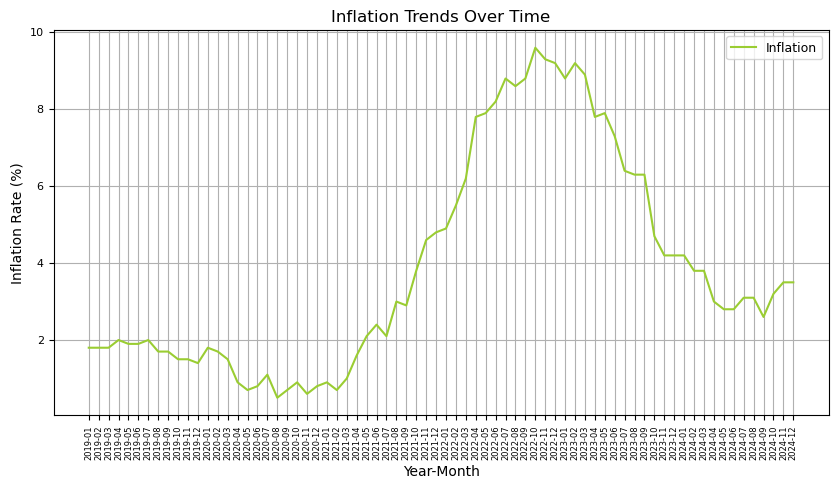

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size
plt.figure(figsize=(10, 5))

# Plot inflation trend with Viridis color
sns.lineplot(x="Year-Month", y="Inflation", data=df_monthly_avg, color="yellowgreen", label="Inflation")

# Formatting
plt.xticks(rotation=90, fontsize=6)  # Vertical alignment for readability
plt.yticks(fontsize=8)
plt.xlabel("Year-Month", fontsize=10)
plt.ylabel("Inflation Rate (%)", fontsize=10)
plt.title("Inflation Trends Over Time", fontsize=12)
plt.legend(fontsize=9)
plt.grid(True)

# Show the plot
plt.show()

### Findings from Inflation Trends Over Time

1. **Sharp Increase in Inflation (2021-2022)**
   - A significant spike in inflation is observed, peaking at nearly **10%** in **mid-2022**.
   - This likely correlates with **post-pandemic supply chain disruptions**, **energy crises**, and **geopolitical instability**.

2. **Gradual Decline in Inflation (2023-2024)**
   - Inflation started **decreasing** after reaching its peak.
   - This suggests that **monetary policies** (e.g., interest rate hikes by the Bank of England) might have been **effective in controlling inflation**.

3. **Initial Stability (2019-2020)**
   - Before 2021, inflation remained **relatively low and stable**, fluctuating around **1-2%**.
   - This indicates a **pre-pandemic economic environment** with controlled price levels.

4. **Post-2024 Trends**
   - Inflation **remains volatile** in late 2023 and early 2024.
   - **Short-term fluctuations** suggest continued uncertainty in economic recovery.

### Next Step: Correlation and Regression Analysis
- "Time Series Regression" – Apply a regression model to analyze inflation trends and predict future values.
- "Rolling Mean / Moving Average" – Smooth fluctuations to observe long-term trends.
- "Seasonality & Trend Decomposition" – Identify underlying inflation patterns over time.

---

### 2.7 Time Series Regression for Inflation
Task: Apply a regression model to analyze inflation trends and predict future values.

Steps:
- Prepare the data – Convert dates into numerical format for regression analysis.
- Train a regression model – Fit a simple linear regression model to identify trends.
- Make predictions – Forecast inflation for upcoming months.
- Visualize the trend – Plot actual vs. predicted values.

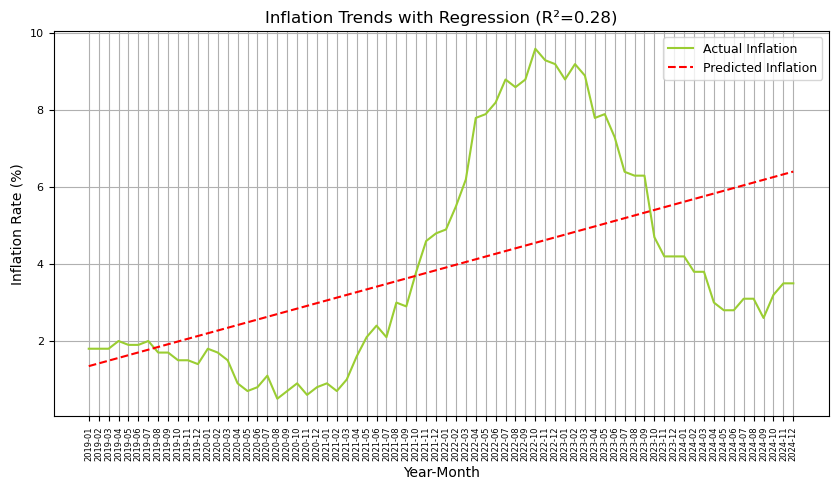

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Convert 'Year-Month' to numerical format for regression (e.g., 2019-01 -> 0, 2019-02 -> 1, etc.)
df_monthly_avg["Month_Index"] = np.arange(len(df_monthly_avg))

# Prepare training data
X = df_monthly_avg[["Month_Index"]]
y = df_monthly_avg["Inflation"]

# Train a simple linear regression model
model = LinearRegression()
model.fit(X, y)

# Make predictions
df_monthly_avg["Predicted_Inflation"] = model.predict(X)

# Compute R² score to evaluate fit
r2 = r2_score(y, df_monthly_avg["Predicted_Inflation"])

# Plot actual vs. predicted inflation trends
plt.figure(figsize=(10, 5))

# Plot actual inflation trend
sns.lineplot(x="Year-Month", y="Inflation", data=df_monthly_avg, label="Actual Inflation", color="yellowgreen")

# Plot regression line (predicted values)
sns.lineplot(x="Year-Month", y="Predicted_Inflation", data=df_monthly_avg, label="Predicted Inflation", color="red", linestyle="dashed")

# Formatting
plt.xticks(rotation=90, fontsize=6)  # Vertical alignment for readability
plt.yticks(fontsize=8)
plt.xlabel("Year-Month", fontsize=10)
plt.ylabel("Inflation Rate (%)", fontsize=10)
plt.title(f"Inflation Trends with Regression (R²={r2:.2f})", fontsize=12)
plt.legend(fontsize=9)
plt.grid(True)

# Show plot
plt.show()

### Findings from Time Series Regression

1. **Weak Predictive Power (R² = 0.28)**
   - The regression model explains only **28% of the variation** in inflation data.
   - This suggests that inflation trends are influenced by **non-linear patterns, external shocks, or seasonality**.

2. **Linear Trend vs. Actual Data**
   - The model captures a **steady increase** in inflation, but it **fails to reflect** major spikes and drops.
   - This indicates that a simple linear regression is **not sufficient** for accurate inflation forecasting.

3. **Inflation Volatility**
   - The actual inflation trend exhibits **sharp fluctuations**, especially between **2021-2023**.
   - A more **complex model**, such as time-series decomposition or moving averages, may better capture these patterns.

### Next Steps
- **Rolling Mean / Moving Average** – Smooth fluctuations to observe long-term trends.
- **Seasonality & Trend Decomposition** – Identify underlying inflation patterns over time.

---

### 2.8 Rolling Mean / Moving Average
**Task:** Apply a moving average to smooth inflation data and observe long-term trends.
#### Steps:
- Compute the **rolling mean** using a **window of 6 months**.
- Plot the **original inflation data** alongside the **smoothed trend**.
- Analyze how the moving average highlights **long-term inflation patterns**.

**Next Steps:**
- **Seasonality & Trend Decomposition** – Break down inflation data into **trend, seasonality, and residuals**.

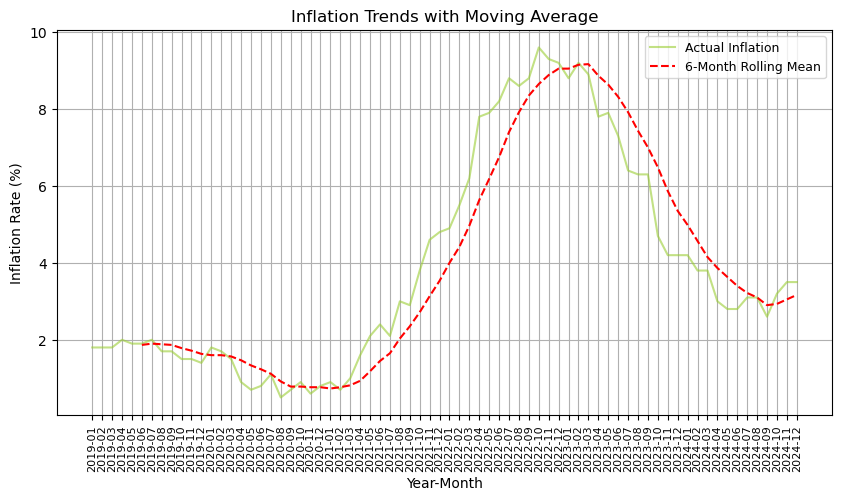

In [14]:
# Set rolling window size (6-month moving average)
window_size = 6
df_monthly_avg["Rolling_Mean"] = df_monthly_avg["Inflation"].rolling(window=window_size).mean()

# Set figure size
plt.figure(figsize=(10, 5))

# Plot actual inflation data
plt.plot(df_monthly_avg["Year-Month"], df_monthly_avg["Inflation"], label="Actual Inflation", color="yellowgreen", alpha=0.6)

# Plot moving average trend
plt.plot(df_monthly_avg["Year-Month"], df_monthly_avg["Rolling_Mean"], label=f"{window_size}-Month Rolling Mean", color="red", linestyle="dashed")

# Formatting
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=10)
plt.xlabel("Year-Month", fontsize=10)
plt.ylabel("Inflation Rate (%)", fontsize=10)
plt.title("Inflation Trends with Moving Average", fontsize=12)
plt.legend(fontsize=9)
plt.grid(True)

# Show the plot
plt.show()

### Findings from Inflation Trends with Moving Average  

#### Smoothing of Short-Term Fluctuations  
- The **6-month rolling average** (red dashed line) smooths out short-term fluctuations, making **long-term trends more visible**.  
- This helps in identifying **consistent inflationary trends** rather than temporary spikes.  

#### Gradual Increase in Inflation (2021-2022)  
- The rolling mean shows a **continuous rise** in inflation from early 2021, peaking around mid-2022.  
- This aligns with external economic factors, such as **global supply chain issues and energy price hikes**.  

#### Peak and Decline (2022-2023)  
- Inflation **steadily declined** after peaking in 2022.  
- The rolling mean highlights this downward trend, confirming a **return to economic stabilization**.  

#### Recent Stability (2023-2024)  
- Inflation appears to have **stabilized** in recent months, with the moving average **flattening out**.  
- This suggests that **monetary policies and economic interventions** may have successfully controlled inflation.  

---

### Next Step: **Seasonality & Trend Decomposition**  
- **Identify underlying patterns** in inflation, including **seasonal effects and long-term trends**.  
- **Use time series decomposition** to separate inflation into **trend, seasonal, and residual components**.  

---

### 2.9 Seasonality & Trend Decomposition
Task:
- Decompose the inflation time series into trend, seasonality, and residual components.
- Identify recurring patterns in inflation over time.
- Analyze long-term trends to understand persistent inflation behavior.

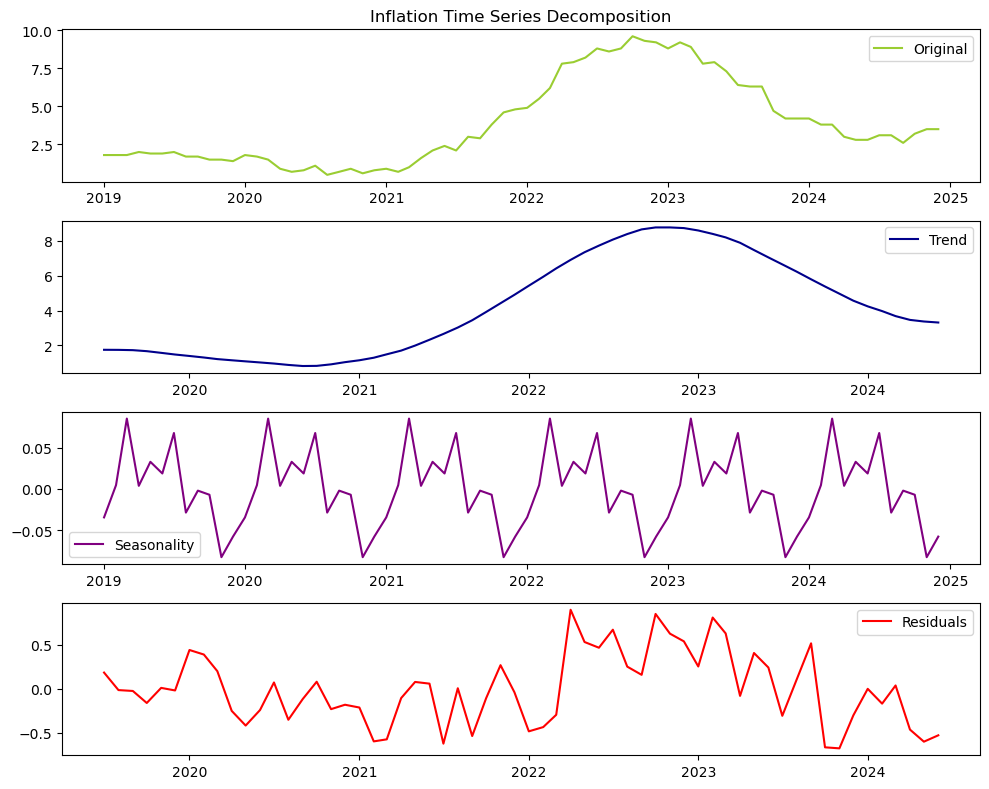

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Ensure date column is in datetime format
df_monthly_avg["Year-Month"] = pd.to_datetime(df_monthly_avg["Year-Month"])

# Set the index to the date column
df_monthly_avg.set_index("Year-Month", inplace=True)

# Perform seasonal decomposition
decomposition = seasonal_decompose(df_monthly_avg["Inflation"], model="additive", period=12)

# Plot decomposition results
plt.figure(figsize=(10, 8))

plt.subplot(4, 1, 1)
plt.plot(df_monthly_avg["Inflation"], label="Original", color="yellowgreen")
plt.legend(loc="best")
plt.title("Inflation Time Series Decomposition")

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label="Trend", color="darkblue")
plt.legend(loc="best")

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label="Seasonality", color="purple")
plt.legend(loc="best")

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label="Residuals", color="red")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

### Findings from Inflation Time Series Decomposition

**1. Overall Inflation Trend**  
- The **trend component** (blue line) shows a **steady rise** in inflation from **2021 to mid-2022**, followed by a **decline from 2023 onward**.  
- This reflects economic changes, possibly driven by **monetary policies, supply chain disruptions, and external factors**.  

**2. Seasonality Component**  
- The **seasonality plot** (purple line) highlights **recurring fluctuations** in inflation.  
- These **seasonal variations** suggest inflation follows **a repeating annual pattern**, potentially influenced by **economic cycles like holiday spending, fiscal policies, or energy price adjustments**.  

**3. Residuals (Unexplained Variations)**  
- The **residual component** (red line) represents **unexplained deviations** after removing trend and seasonality.  
- Some **noticeable spikes** indicate **unexpected economic shocks**, possibly related to **geopolitical events or sudden policy shifts**.  

**4. Key Observations**  
- The **upward inflation trend (2021-2022)** coincides with **global economic challenges**.  
- The **decline from 2023 onward** suggests that **inflation control measures were effective**.  
- **Predictable seasonal patterns** help in forecasting, but **random residual spikes** show **occasional external shocks** affecting inflation.  

This decomposition helps in understanding **long-term trends, seasonal cycles, and unexpected disruptions** in inflation dynamics.

---

## Summary of Completed Work

### **1. Data Collection & Preparation**
- Imported inflation data from **ONS (Office for National Statistics)**.
- Processed and cleaned the dataset:
  - Extracted relevant columns (**Date, Inflation**).
  - Converted date formats from various representations (**YYYY, YYYY-QX, YYYY-MMM**) into a standardized **datetime** format.
  - Filtered data to focus on the period **2019-01 to 2024-12**.
  - Saved the cleaned dataset for further analysis.

### **2. Data Aggregation & Quality Checks**
- Converted **daily inflation records** into **monthly averages**.
- Performed **data quality checks**:
  - Verified **missing values, duplicate records, and zero values**.
  - Ensured dataset consistency and integrity.

### **3. Exploratory Data Analysis (EDA)**
- Conducted **statistical summary** (mean, min, max, quartiles).
- Visualized inflation trends over time using:
  - **Line chart** to observe general inflation behavior.
  - **Rolling mean (6-month moving average)** to smooth out short-term fluctuations.
  - **Time series decomposition** to separate trend, seasonality, and residuals.

### **4. Time Series Regression**
- Applied a **simple linear regression model** to analyze inflation trends.
- Evaluated model performance (**R² = 0.28**), indicating a weak linear relationship due to external economic factors.

### **5. Seasonality & Trend Decomposition**
- Identified **recurring seasonal inflation patterns** and long-term trends.
- Examined residual components to detect **unexpected economic shocks**.